# Extrapolation methods

 - Density estimation with Normalizing Flow
 - Unbinned Rerighting MC $\to$ data
 - ABCD

## Density estimation with Normalizing Flow

### Toy example

Use variables $\alpha$ and $\beta$ to define SR.

$$
p(\alpha)=\frac{1}{\sqrt{2 \pi}} e^{-\frac{\alpha^{2}}{2}}
$$

$$
p(\beta)=\frac{1}{\sqrt{2 \pi}} e^{-\frac{\beta^{2}}{2}}
$$

Use variable $y$ which is a function of $\alpha$ and $\beta$ as to do the likelihood fit.

$$
y = e^{- (\alpha + \beta)^2}
$$

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
import matplotlib.pyplot as plt

2023-01-18 22:13:31.595510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorfl

<function matplotlib.pyplot.show(close=None, block=None)>

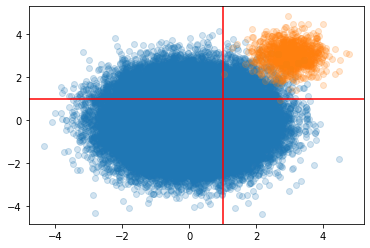

In [84]:
n1 = 100000
# Background
x1 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
x2 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
plt.scatter(x1, x2, alpha = 0.2)
data = np.stack([x1, x2], axis = -1)
# Signal
n2 = 1000
x3 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
x4 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
plt.scatter(x3, x4, alpha = 0.2)
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.show

In [82]:
# Density estimation with MADE.
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[128,128])
distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made))

# Construct and fit model.
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)
model.compile(optimizer=tf.optimizers.Adam(),loss=lambda _, log_prob: -log_prob)
batch_size = 512

In [83]:
# Train on full background distribution
model.fit(x=data,
          y=np.zeros((n1, 0), dtype=np.float32),
          batch_size=batch_size,
          epochs=20,
          steps_per_epoch=100, # Usually `n // batch_size`.
          shuffle=True,
          verbose=True)

Epoch 1/20
100/100 [==============================] - 1s 3ms/step - loss: 2.8392
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 2.8441
Epoch 3/20
100/100 [==============================] - 0s 3ms/step - loss: 2.8443
Epoch 4/20
100/100 [==============================] - 0s 3ms/step - loss: 2.8380
Epoch 5/20
100/100 [==============================] - 0s 3ms/step - loss: 2.8368
Epoch 6/20
100/100 [==============================] - 0s 3ms/step - loss: 2.8426
Epoch 7/20
100/100 [==============================] - 0s 3ms/step - loss: 2.8400
Epoch 8/20
100/100 [==============================] - 0s 3ms/step - loss: 2.8388
Epoch 9/20
100/100 [==============================] - 0s 3ms/step - loss: 2.8430
Epoch 10/20
100/100 [==============================] - 0s 3ms/step - loss: 2.8340
Epoch 11/20
100/100 [==============================] - 0s 4ms/step - loss: 2.8387
Epoch 12/20
100/100 [==============================] - 0s 3ms/step - loss: 2.8412
Epoch 13/20
100/100 [====

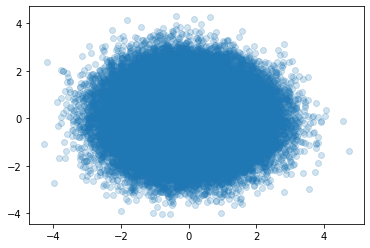

In [85]:
# Predict the full background distribution
samples = distribution.sample((100000,1))
sample2 = samples[:,0]
y1 = sample2[:,0]
y2 = sample2[:,1]
plt.scatter(y1, y2, alpha = 0.2)
plt.show()

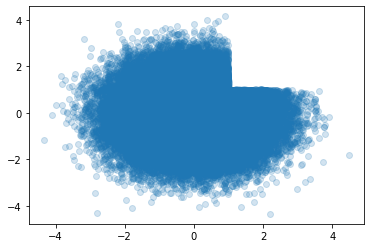

In [87]:
# Train on background distribution in CR
data2 = data[np.logical_not((data[:,0] > 1) & (data[:,1] > 1))]

# Plot partial background that's been trained on
x5 = data2[:,0]
x6 = data2[:,1]
plt.scatter(x5, x6, alpha = 0.2)
plt.show()

In [88]:
# Redefine the model
# Density estimation with MADE.
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[128,128])
distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made))

# Construct and fit model.
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)
model.compile(optimizer=tf.optimizers.Adam(),loss=lambda _, log_prob: -log_prob)
batch_size = 512

# Train
model.fit(x=data2,
          y=np.zeros((len(data2), 0), dtype=np.float32),
          batch_size=batch_size,
          epochs=20,
          steps_per_epoch=100, # Usually `n // batch_size`.
          shuffle=True,
          verbose=True)

Epoch 1/20
100/100 [==============================] - 1s 3ms/step - loss: 2.7940
Epoch 2/20
100/100 [==============================] - 0s 3ms/step - loss: 2.7856
Epoch 3/20
100/100 [==============================] - 0s 3ms/step - loss: 2.7867
Epoch 4/20
100/100 [==============================] - 0s 3ms/step - loss: 2.7854
Epoch 5/20
100/100 [==============================] - 0s 3ms/step - loss: 2.7880
Epoch 6/20
100/100 [==============================] - 0s 3ms/step - loss: 2.7916
Epoch 7/20
100/100 [==============================] - 0s 3ms/step - loss: 2.7841
Epoch 8/20
100/100 [==============================] - 0s 3ms/step - loss: 2.7920
Epoch 9/20
100/100 [==============================] - 0s 3ms/step - loss: 2.7877
Epoch 10/20
100/100 [==============================] - 0s 3ms/step - loss: 2.7831
Epoch 11/20
100/100 [==============================] - 0s 3ms/step - loss: 2.7877
Epoch 12/20
100/100 [==============================] - 0s 3ms/step - loss: 2.7873
Epoch 13/20
100/100 [====

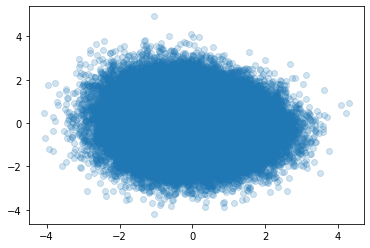

In [89]:
# Predict the full background distribution
samples = distribution.sample((100000,1))
sample2 = samples[:,0]
y1 = sample2[:,0]
y2 = sample2[:,1]
plt.scatter(y1, y2, alpha = 0.2)
plt.show()